# Phase 6B: Fully Integrated Quantum-Enhanced World Model

**Quantum-Enhanced Simulation Learning for Reinforcement Learning**

Author: Saurabh Jalendra  
Institution: BITS Pilani (WILP Division)  
Date: December 2025

---

## Overview

This notebook implements the **Fully Integrated** approach that combines ALL quantum-inspired components:

| Component | Source | Target Bottleneck |
|-----------|--------|-------------------|
| QAOA Optimizer | Notebook 03 | Local Minima |
| Superposition Replay | Notebook 04 | Sample Inefficiency |
| Gate-Enhanced Layers | Notebook 05 | Slow Convergence |
| Error Correction Ensemble | Notebook 06 | Compounding Errors |

**Research Question:** Does combining all quantum-inspired methods provide better results than any single method alone?

## 6B.1 Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import json
import time
from scipy import stats

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Standard seeds per CLAUDE.md
EXPERIMENT_SEEDS = [42, 123, 456, 789, 1024]

# Standard configuration (consistent with all notebooks)
CONFIG = {
    'obs_dim': 4,
    'action_dim': 2,
    'stoch_dim': 64,
    'deter_dim': 512,
    'hidden_dim': 512,
    'batch_size': 32,
    'seq_len': 20,
    'num_epochs': 50,
    'learning_rate': 3e-4,
    'num_episodes': 100,
    'num_ensemble': 5,
    'seeds': EXPERIMENT_SEEDS,
}

print(f'Configuration: {CONFIG}')
print(f'Experiment seeds: {EXPERIMENT_SEEDS}')

Using device: cuda
Configuration: {'obs_dim': 4, 'action_dim': 2, 'stoch_dim': 64, 'deter_dim': 512, 'hidden_dim': 512, 'batch_size': 32, 'seq_len': 20, 'num_epochs': 50, 'learning_rate': 0.0003, 'num_episodes': 100, 'num_ensemble': 5, 'seeds': [42, 123, 456, 789, 1024]}
Experiment seeds: [42, 123, 456, 789, 1024]


## 6B.2 Component 1: Gate-Enhanced Layers

Quantum gate-inspired neural network layers for richer representations.

In [2]:
class HadamardLayer(nn.Module):
    """Hadamard-inspired feature mixing layer."""
    
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
        # Learnable Hadamard-like transformation
        self.weight = nn.Parameter(torch.randn(dim, dim) / np.sqrt(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
        # Make it close to orthogonal
        nn.init.orthogonal_(self.weight)
    
    def forward(self, x):
        # Apply Hadamard-like mixing
        return F.linear(x, self.weight, self.bias)


class PhaseLayer(nn.Module):
    """Phase gate-inspired modulation layer."""
    
    def __init__(self, dim: int):
        super().__init__()
        self.phase = nn.Parameter(torch.zeros(dim))
    
    def forward(self, x):
        # Apply learnable phase modulation
        return x * torch.cos(self.phase) + torch.roll(x, 1, dims=-1) * torch.sin(self.phase)


class EntanglementLayer(nn.Module):
    """CNOT-inspired entanglement layer."""
    
    def __init__(self, dim: int, num_pairs: int = 4):
        super().__init__()
        self.dim = dim
        self.num_pairs = min(num_pairs, dim // 2)
        self.control_weights = nn.Parameter(torch.randn(self.num_pairs))
    
    def forward(self, x):
        # Avoid inplace operations by building output piece by piece
        # Split input into chunks and process each pair
        chunks = list(x.split(1, dim=-1))
        
        for i in range(self.num_pairs):
            control_idx = i * 2
            target_idx = i * 2 + 1
            if target_idx < self.dim:
                # CNOT-like: target XOR control (soft version)
                gate = torch.sigmoid(self.control_weights[i])
                control = chunks[control_idx]
                target = chunks[target_idx]
                # Create new tensor instead of inplace modification
                new_target = target * (1 - gate) + (target * control) * gate
                chunks[target_idx] = new_target
        
        return torch.cat(chunks, dim=-1)


class QuantumGateBlock(nn.Module):
    """Combined quantum gate block with all gate types."""
    
    def __init__(self, dim: int, use_hadamard: bool = True, use_phase: bool = True, use_entangle: bool = True):
        super().__init__()
        layers = []
        if use_hadamard:
            layers.append(HadamardLayer(dim))
            layers.append(nn.ELU())
        if use_phase:
            layers.append(PhaseLayer(dim))
        if use_entangle:
            layers.append(EntanglementLayer(dim))
        layers.append(nn.LayerNorm(dim))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x) + x  # Residual connection

print('Gate-Enhanced Layers defined.')

Gate-Enhanced Layers defined.


## 6B.3 Component 2: Gate-Enhanced World Model

World model with quantum gate layers integrated into encoder, decoder, and RSSM.

In [3]:
class GateEnhancedWorldModel(nn.Module):
    """
    World model with quantum gate-enhanced layers.

    Matches baseline architecture from notebook 02 with quantum gate additions:
    - input_proj: Linear(stoch + action, hidden) + ELU
    - gru: GRUCell(hidden, deter)
    - prior: 2-layer (same as baseline)
    - posterior: 2-layer (same as baseline)
    - encoder/decoder: [512, 512] with QuantumGateBlock
    """

    def __init__(self, obs_dim: int, action_dim: int, config: Dict):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.stoch_dim = config.get('stoch_dim', 64)
        self.deter_dim = config.get('deter_dim', 512)
        self.hidden_dim = config.get('hidden_dim', 512)
        self.state_dim = self.stoch_dim + self.deter_dim

        predictor_hidden = [512, 512]

        # Gate-enhanced encoder (matching baseline [512, 512] architecture)
        self.encoder = nn.Sequential(
            nn.Linear(obs_dim, self.hidden_dim),
            nn.ELU(),
            QuantumGateBlock(self.hidden_dim),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(),
        )

        # RSSM - matches baseline EXACTLY
        # Input projection (same as baseline)
        self.input_proj = nn.Sequential(
            nn.Linear(self.stoch_dim + action_dim, self.hidden_dim),
            nn.ELU()
        )

        self.gru = nn.GRUCell(self.hidden_dim, self.deter_dim)

        # Prior: 2-layer (matches baseline)
        self.prior = nn.Sequential(
            nn.Linear(self.deter_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.stoch_dim * 2)
        )

        # Posterior: 2-layer (matches baseline)
        self.posterior = nn.Sequential(
            nn.Linear(self.deter_dim + self.hidden_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.stoch_dim * 2)
        )

        # Gate-enhanced decoder (matching baseline [512, 512] architecture)
        self.decoder = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ELU(),
            QuantumGateBlock(self.hidden_dim),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, obs_dim * 2)
        )

        # Reward predictor (using predictor_hidden)
        rew_layers = []
        in_d = self.state_dim
        for h in predictor_hidden:
            rew_layers.extend([nn.Linear(in_d, h), nn.ELU()])
            in_d = h
        rew_layers.append(nn.Linear(in_d, 1))
        self.reward_pred = nn.Sequential(*rew_layers)

    def initial_state(self, batch_size: int):
        return {
            'deter': torch.zeros(batch_size, self.deter_dim, device=DEVICE),
            'stoch': torch.zeros(batch_size, self.stoch_dim, device=DEVICE)
        }

    def get_dist(self, stats):
        mean, log_std = stats.chunk(2, dim=-1)
        std = F.softplus(log_std) + 0.1
        return torch.distributions.Normal(mean, std)

    def forward(self, obs_seq, action_seq):
        batch_size, seq_len = obs_seq.shape[:2]

        state = self.initial_state(batch_size)

        prior_means, prior_stds = [], []
        post_means, post_stds = [], []
        obs_means, obs_stds = [], []
        rewards = []
        states = []

        for t in range(seq_len):
            embed = self.encoder(obs_seq[:, t])

            # Prior (before seeing observation)
            prior_stats = self.prior(state['deter'])
            prior_dist = self.get_dist(prior_stats)

            # Posterior (after seeing observation)
            post_input = torch.cat([state['deter'], embed], dim=-1)
            post_stats = self.posterior(post_input)
            post_dist = self.get_dist(post_stats)

            # Sample stochastic state
            stoch = post_dist.rsample()

            # Update deterministic state (through input_proj like baseline)
            gru_input = self.input_proj(torch.cat([stoch, action_seq[:, t]], dim=-1))
            deter = self.gru(gru_input, state['deter'])

            # Full state
            full_state = torch.cat([deter, stoch], dim=-1)

            # Decode observation
            obs_stats = self.decoder(full_state)
            obs_mean, obs_log_std = obs_stats.chunk(2, dim=-1)
            obs_std = F.softplus(obs_log_std) + 0.1

            # Predict reward
            reward = self.reward_pred(full_state)

            # Store outputs
            prior_means.append(prior_dist.mean)
            prior_stds.append(prior_dist.stddev)
            post_means.append(post_dist.mean)
            post_stds.append(post_dist.stddev)
            obs_means.append(obs_mean)
            obs_stds.append(obs_std)
            rewards.append(reward)
            states.append(full_state)

            state = {'deter': deter, 'stoch': stoch}

        return {
            'prior_mean': torch.stack(prior_means, dim=1),
            'prior_std': torch.stack(prior_stds, dim=1),
            'post_mean': torch.stack(post_means, dim=1),
            'post_std': torch.stack(post_stds, dim=1),
            'obs_mean': torch.stack(obs_means, dim=1),
            'obs_std': torch.stack(obs_stds, dim=1),
            'reward': torch.stack(rewards, dim=1).squeeze(-1),
            'states': torch.stack(states, dim=1)
        }

    def imagine(self, initial_state, actions):
        """Imagine future states given actions."""
        batch_size = actions.shape[0]
        horizon = actions.shape[1]

        state = {'deter': initial_state['deter'].clone(),
                 'stoch': initial_state['stoch'].clone()}

        states = []
        obs_preds = []
        reward_preds = []

        for t in range(horizon):
            gru_input = self.input_proj(torch.cat([state['stoch'], actions[:, t]], dim=-1))
            deter = self.gru(gru_input, state['deter'])

            prior_stats = self.prior(deter)
            prior_dist = self.get_dist(prior_stats)
            stoch = prior_dist.rsample()

            full_state = torch.cat([deter, stoch], dim=-1)
            states.append(full_state)

            obs_stats = self.decoder(full_state)
            obs_mean, _ = obs_stats.chunk(2, dim=-1)
            obs_preds.append(obs_mean)

            reward = self.reward_pred(full_state)
            reward_preds.append(reward)

            state = {'deter': deter, 'stoch': stoch}

        return {
            'states': torch.stack(states, dim=1),
            'obs_pred': torch.stack(obs_preds, dim=1),
            'reward_pred': torch.stack(reward_preds, dim=1).squeeze(-1)
        }


## 6B.4 Component 3: Error Correction Ensemble

Ensemble of gate-enhanced models with majority voting for robust predictions.

In [4]:
class ErrorCorrectionEnsemble(nn.Module):
    """Ensemble of gate-enhanced world models with error correction."""
    
    def __init__(self, obs_dim: int, action_dim: int, config: Dict, num_models: int = 5):
        super().__init__()
        self.num_models = num_models
        self.models = nn.ModuleList([
            GateEnhancedWorldModel(obs_dim, action_dim, config)
            for _ in range(num_models)
        ])
        self.correction_method = config.get('correction_method', 'weighted')
    
    def forward(self, obs_seq, action_seq, return_all: bool = False):
        # Get predictions from all models
        all_outputs = [model(obs_seq, action_seq) for model in self.models]
        
        # Stack predictions
        obs_preds = torch.stack([out['obs_mean'] for out in all_outputs], dim=0)
        reward_preds = torch.stack([out['reward'] for out in all_outputs], dim=0)
        
        # Apply error correction
        if self.correction_method == 'majority':
            corrected_obs = obs_preds.median(dim=0).values
            corrected_reward = reward_preds.median(dim=0).values
        elif self.correction_method == 'weighted':
            # Weight by inverse disagreement
            disagreement = obs_preds.var(dim=0, keepdim=True)
            weights = 1.0 / (disagreement.mean(dim=-1, keepdim=True) + 1e-6)
            weights = weights / weights.sum(dim=0, keepdim=True)
            corrected_obs = (obs_preds * weights).sum(dim=0)
            corrected_reward = (reward_preds * weights.squeeze(-1)).sum(dim=0)
        else:  # simple average
            corrected_obs = obs_preds.mean(dim=0)
            corrected_reward = reward_preds.mean(dim=0)
        
        # Calculate uncertainty
        uncertainty = obs_preds.std(dim=0).mean(dim=-1)
        
        result = {
            'obs_mean': corrected_obs,
            'reward': corrected_reward,
            'uncertainty': uncertainty,
            'prior_mean': all_outputs[0]['prior_mean'],
            'prior_std': all_outputs[0]['prior_std'],
            'post_mean': all_outputs[0]['post_mean'],
            'post_std': all_outputs[0]['post_std'],
            'obs_std': all_outputs[0]['obs_std'],
        }
        
        if return_all:
            result['all_outputs'] = all_outputs
        
        return result

# Test
ensemble = ErrorCorrectionEnsemble(CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG, num_models=5).to(DEVICE)
print(f'ErrorCorrectionEnsemble total parameters: {sum(p.numel() for p in ensemble.parameters()):,}')

ErrorCorrectionEnsemble total parameters: 22,217,045


## 6B.5 Component 4: Superposition Replay Buffer

Experience replay with quantum superposition-inspired sampling.

In [5]:
@dataclass
class Episode:
    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    total_reward: float


class SuperpositionReplayBuffer:
    """Replay buffer with quantum superposition-inspired sampling."""
    
    def __init__(self, capacity: int = 1000, parallel_samples: int = 4):
        self.capacity = capacity
        self.parallel_samples = parallel_samples
        self.episodes: List[Episode] = []
        self.amplitudes: np.ndarray = np.array([])
    
    def add_episode(self, episode: Episode):
        if len(self.episodes) >= self.capacity:
            self.episodes.pop(0)
        self.episodes.append(episode)
        self._update_amplitudes()
    
    def _update_amplitudes(self):
        """Update quantum-like amplitudes based on episode quality."""
        if not self.episodes:
            self.amplitudes = np.array([])
            return
        
        rewards = np.array([ep.total_reward for ep in self.episodes])
        # Normalize to create amplitude distribution
        if rewards.std() > 0:
            normalized = (rewards - rewards.mean()) / rewards.std()
        else:
            normalized = np.zeros_like(rewards)
        
        # Convert to probabilities (amplitude squared)
        amplitudes = np.exp(normalized)
        self.amplitudes = amplitudes / amplitudes.sum()
    
    def sample_superposition(self, batch_size: int, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Sample using superposition-inspired parallel sampling."""
        if len(self.episodes) < self.parallel_samples:
            return self.sample_standard(batch_size, seq_len)
        
        # Sample multiple episodes in parallel (superposition)
        obs_batch, act_batch, rew_batch = [], [], []
        
        for _ in range(batch_size):
            # Sample parallel_samples episodes based on amplitudes
            indices = np.random.choice(
                len(self.episodes), 
                size=self.parallel_samples,
                p=self.amplitudes,
                replace=True
            )
            
            # "Collapse" to one by weighted combination
            selected_amplitudes = self.amplitudes[indices]
            collapse_probs = selected_amplitudes / selected_amplitudes.sum()
            chosen_idx = np.random.choice(indices, p=collapse_probs)
            
            episode = self.episodes[chosen_idx]
            
            # Random start point
            max_start = max(0, len(episode.observations) - seq_len)
            start = np.random.randint(0, max_start + 1) if max_start > 0 else 0
            end = min(start + seq_len, len(episode.observations))
            
            obs = episode.observations[start:end]
            act = episode.actions[start:end]
            rew = episode.rewards[start:end]
            
            # Pad if necessary
            if len(obs) < seq_len:
                pad_len = seq_len - len(obs)
                obs = np.pad(obs, ((0, pad_len), (0, 0)), mode='edge')
                act = np.pad(act, ((0, pad_len), (0, 0)), mode='edge')
                rew = np.pad(rew, (0, pad_len), mode='edge')
            
            obs_batch.append(obs)
            act_batch.append(act)
            rew_batch.append(rew)
        
        return (
            torch.FloatTensor(np.array(obs_batch)).to(DEVICE),
            torch.FloatTensor(np.array(act_batch)).to(DEVICE),
            torch.FloatTensor(np.array(rew_batch)).to(DEVICE)
        )
    
    def sample_standard(self, batch_size: int, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Standard uniform sampling."""
        obs_batch, act_batch, rew_batch = [], [], []
        
        for _ in range(batch_size):
            episode = np.random.choice(self.episodes)
            max_start = max(0, len(episode.observations) - seq_len)
            start = np.random.randint(0, max_start + 1) if max_start > 0 else 0
            end = min(start + seq_len, len(episode.observations))
            
            obs = episode.observations[start:end]
            act = episode.actions[start:end]
            rew = episode.rewards[start:end]
            
            if len(obs) < seq_len:
                pad_len = seq_len - len(obs)
                obs = np.pad(obs, ((0, pad_len), (0, 0)), mode='edge')
                act = np.pad(act, ((0, pad_len), (0, 0)), mode='edge')
                rew = np.pad(rew, (0, pad_len), mode='edge')
            
            obs_batch.append(obs)
            act_batch.append(act)
            rew_batch.append(rew)
        
        return (
            torch.FloatTensor(np.array(obs_batch)).to(DEVICE),
            torch.FloatTensor(np.array(act_batch)).to(DEVICE),
            torch.FloatTensor(np.array(rew_batch)).to(DEVICE)
        )
    
    def __len__(self):
        return len(self.episodes)

print('SuperpositionReplayBuffer defined.')

SuperpositionReplayBuffer defined.


## 6B.6 Component 5: QAOA-Inspired Optimizer

Optimizer that alternates between cost and mixing operators to escape local minima.

In [6]:
class QAOAOptimizer:
    """QAOA-inspired optimizer with alternating cost/mixing phases."""
    
    def __init__(self, params, lr: float = 3e-4, p_layers: int = 4,
                 gamma_init: float = 0.1, beta_init: float = 0.001):
        self.params = list(params)
        self.lr = lr
        self.p_layers = p_layers
        
        # QAOA parameters
        self.gammas = [gamma_init] * p_layers
        self.betas = [beta_init] * p_layers
        
        # Base optimizer
        self.base_optimizer = torch.optim.Adam(self.params, lr=lr)
        
        # State tracking
        self.step_count = 0
        self.current_layer = 0
    
    def zero_grad(self):
        self.base_optimizer.zero_grad()
    
    def step(self):
        """Perform QAOA-inspired optimization step."""
        self.step_count += 1
        layer_idx = self.current_layer % self.p_layers
        
        # Cost phase: gradient descent with gamma scaling
        gamma = self.gammas[layer_idx]
        with torch.no_grad():
            for param in self.params:
                if param.grad is not None:
                    param.grad.mul_(gamma)
        
        self.base_optimizer.step()
        
        # Mixing phase: add exploration noise (every other step)
        if self.step_count % 2 == 0:
            beta = self.betas[layer_idx]
            with torch.no_grad():
                for param in self.params:
                    if param.requires_grad:
                        noise = torch.randn_like(param) * beta * self.lr
                        param.add_(noise)
            self.current_layer += 1
    
    def state_dict(self):
        return {
            'base_optimizer': self.base_optimizer.state_dict(),
            'step_count': self.step_count,
            'gammas': self.gammas,
            'betas': self.betas,
        }
    
    def load_state_dict(self, state_dict):
        self.base_optimizer.load_state_dict(state_dict['base_optimizer'])
        self.step_count = state_dict['step_count']
        self.gammas = state_dict['gammas']
        self.betas = state_dict['betas']

print('QAOAOptimizer defined.')

QAOAOptimizer defined.


## 6B.7 Fully Integrated Trainer

Training loop that combines all quantum-inspired components.

In [7]:
class FullyIntegratedTrainer:
    """
    Fully integrated trainer combining:
    - QAOA optimizer (escapes local minima)
    - Superposition replay (sample efficiency)
    - Gate-enhanced layers (better representations)
    - Error correction ensemble (robust predictions)
    """
    
    def __init__(self, ensemble: ErrorCorrectionEnsemble, buffer: SuperpositionReplayBuffer,
                 config: Dict):
        self.ensemble = ensemble
        self.buffer = buffer
        self.config = config
        
        # Create QAOA optimizer for each model in ensemble
        self.optimizers = [
            QAOAOptimizer(
                model.parameters(),
                lr=config.get('learning_rate', 3e-4),
                p_layers=config.get('qaoa_layers', 4),
                gamma_init=config.get('gamma_init', 0.1),
                beta_init=config.get('beta_init', 0.001)
            )
            for model in ensemble.models
        ]
        
        self.training_history = defaultdict(list)
    
    def compute_loss(self, outputs: Dict, obs_seq: torch.Tensor, reward_seq: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        """Compute world model loss."""
        # Reconstruction loss
        recon_loss = F.mse_loss(outputs['obs_mean'], obs_seq)
        
        # KL divergence
        prior_dist = torch.distributions.Normal(outputs['prior_mean'], outputs['prior_std'])
        post_dist = torch.distributions.Normal(outputs['post_mean'], outputs['post_std'])
        kl_loss = torch.distributions.kl_divergence(post_dist, prior_dist).mean()
        kl_loss = torch.clamp(kl_loss, min=1.0)  # Free bits
        
        # Reward loss
        reward_loss = F.mse_loss(outputs['reward'], reward_seq)
        
        # Total loss
        total_loss = recon_loss + 0.1 * kl_loss + reward_loss
        
        metrics = {
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item(),
            'reward_loss': reward_loss.item(),
            'total_loss': total_loss.item(),
        }
        
        return total_loss, metrics
    
    def train_step(self, use_superposition: bool = True) -> Dict:
        """Single training step with all quantum components."""
        self.ensemble.train()
        
        # Sample using superposition replay
        if use_superposition:
            obs_seq, action_seq, reward_seq = self.buffer.sample_superposition(
                self.config['batch_size'], self.config['seq_len']
            )
        else:
            obs_seq, action_seq, reward_seq = self.buffer.sample_standard(
                self.config['batch_size'], self.config['seq_len']
            )
        
        total_loss = 0.0
        all_metrics = defaultdict(list)
        
        # Train each model in ensemble with QAOA optimizer
        for model, optimizer in zip(self.ensemble.models, self.optimizers):
            optimizer.zero_grad()
            
            outputs = model(obs_seq, action_seq)
            loss, metrics = self.compute_loss(outputs, obs_seq, reward_seq)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 100.0)
            optimizer.step()
            
            total_loss += loss.item()
            for k, v in metrics.items():
                all_metrics[k].append(v)
        
        # Average metrics
        avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
        avg_metrics['ensemble_loss'] = total_loss / len(self.ensemble.models)
        
        return avg_metrics
    
    def train(self, num_epochs: int, use_superposition: bool = True) -> Dict:
        """Full training loop."""
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_metrics = defaultdict(list)
            
            # Multiple steps per epoch
            num_steps = max(1, len(self.buffer) // self.config['batch_size'])
            for _ in range(num_steps):
                metrics = self.train_step(use_superposition)
                for k, v in metrics.items():
                    epoch_metrics[k].append(v)
            
            # Average epoch metrics
            for k, v in epoch_metrics.items():
                self.training_history[k].append(np.mean(v))
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}: Loss = {self.training_history['total_loss'][-1]:.4f}")
        
        training_time = time.time() - start_time
        self.training_history['training_time'] = training_time
        
        return dict(self.training_history)
    
    def evaluate(self, test_obs: torch.Tensor, test_actions: torch.Tensor) -> Dict:
        """Evaluate the ensemble."""
        self.ensemble.eval()
        with torch.no_grad():
            outputs = self.ensemble(test_obs, test_actions, return_all=True)
            
            # Ensemble prediction error
            ensemble_mse = F.mse_loss(outputs['obs_mean'], test_obs).item()
            
            # Individual model errors
            individual_mses = []
            for out in outputs['all_outputs']:
                mse = F.mse_loss(out['obs_mean'], test_obs).item()
                individual_mses.append(mse)
            
            # Uncertainty
            mean_uncertainty = outputs['uncertainty'].mean().item()
        
        return {
            'ensemble_mse': ensemble_mse,
            'avg_individual_mse': np.mean(individual_mses),
            'best_individual_mse': min(individual_mses),
            'worst_individual_mse': max(individual_mses),
            'mean_uncertainty': mean_uncertainty,
        }

print('FullyIntegratedTrainer defined.')

FullyIntegratedTrainer defined.


## 6B.8 Long-Horizon Prediction Test

Test multi-step prediction accuracy (critical for world models used in planning).

In [8]:
# Standard horizons per CLAUDE.md
LONG_HORIZON_HORIZONS = [5, 10, 15, 20, 30, 40, 50]

def evaluate_long_horizon(model, obs_seq: torch.Tensor, action_seq: torch.Tensor, 
                          horizons: List[int] = None) -> Dict:
    """
    Evaluate prediction accuracy at different horizons.
    
    This is critical because world models are used for PLANNING,
    which requires accurate predictions many steps into the future.
    """
    if horizons is None:
        horizons = LONG_HORIZON_HORIZONS
    
    model.eval()
    results = {}
    
    with torch.no_grad():
        # Get model predictions
        if hasattr(model, 'models'):  # Ensemble
            outputs = model(obs_seq, action_seq)
            pred_obs = outputs['obs_mean']
        else:  # Single model
            outputs = model(obs_seq, action_seq)
            pred_obs = outputs['obs_mean']
        
        # Calculate error at each horizon
        for h in horizons:
            if h <= obs_seq.shape[1]:
                # MSE at horizon h
                mse_at_h = F.mse_loss(pred_obs[:, h-1:h], obs_seq[:, h-1:h]).item()
                results[f'mse_horizon_{h}'] = mse_at_h
        
        # Average error over all horizons
        results['avg_horizon_mse'] = np.mean([v for k, v in results.items() if 'mse_horizon' in k])
        
        # Error growth rate (how fast does error compound?)
        if len(horizons) >= 2:
            first_h = horizons[0]
            last_h = min(horizons[-1], obs_seq.shape[1])
            if f'mse_horizon_{first_h}' in results and f'mse_horizon_{last_h}' in results:
                error_growth = results[f'mse_horizon_{last_h}'] / (results[f'mse_horizon_{first_h}'] + 1e-8)
                results['error_growth_rate'] = error_growth
    
    return results

print(f'Long-horizon evaluation function defined.')
print(f'Standard horizons: {LONG_HORIZON_HORIZONS}')

Long-horizon evaluation function defined.
Standard horizons: [5, 10, 15, 20, 30, 40, 50]


## 6B.9 Data Collection

In [9]:
def collect_episodes(env_name: str, num_episodes: int, seed: int = 42) -> List[Episode]:
    """Collect episodes from environment."""
    env = gym.make(env_name)
    episodes = []
    
    for ep in range(num_episodes):
        obs, _ = env.reset(seed=seed + ep)
        observations, actions, rewards = [obs], [], []
        
        done = False
        while not done:
            action = env.action_space.sample()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # One-hot encode action for discrete spaces
            if isinstance(env.action_space, gym.spaces.Discrete):
                action_onehot = np.zeros(env.action_space.n)
                action_onehot[action] = 1
                actions.append(action_onehot)
            else:
                actions.append(action)
            
            rewards.append(reward)
            observations.append(next_obs)
        
        episodes.append(Episode(
            observations=np.array(observations[:-1]),
            actions=np.array(actions),
            rewards=np.array(rewards),
            total_reward=sum(rewards)
        ))
    
    env.close()
    avg_reward = np.mean([ep.total_reward for ep in episodes])
    avg_length = np.mean([len(ep.observations) for ep in episodes])
    print(f'Collected {num_episodes} episodes, avg reward: {avg_reward:.1f}, avg length: {avg_length:.1f}')
    return episodes

# Collect data
print('Collecting training data...')
episodes = collect_episodes('CartPole-v1', CONFIG['num_episodes'], seed=42)

Collected 100 episodes, avg reward: 21.4, avg length: 21.4


## 6B.10 Classical Baseline for Comparison

In [10]:
class ClassicalWorldModel(nn.Module):
    """
    Standard world model without quantum enhancements (for comparison).

    Matches baseline architecture from notebook 02 EXACTLY:
    - input_proj: Linear(stoch + action, hidden) + ELU
    - gru: GRUCell(hidden, deter)
    - prior: 2-layer
    - posterior: 2-layer
    """

    def __init__(self, obs_dim: int, action_dim: int, config: Dict):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.stoch_dim = config.get('stoch_dim', 64)
        self.deter_dim = config.get('deter_dim', 512)
        self.hidden_dim = config.get('hidden_dim', 512)
        self.state_dim = self.stoch_dim + self.deter_dim

        predictor_hidden = [512, 512]

        # Standard encoder (matching baseline [512, 512] architecture)
        self.encoder = nn.Sequential(
            nn.Linear(obs_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(),
        )

        # RSSM - matches baseline EXACTLY
        self.input_proj = nn.Sequential(
            nn.Linear(self.stoch_dim + action_dim, self.hidden_dim),
            nn.ELU()
        )

        self.gru = nn.GRUCell(self.hidden_dim, self.deter_dim)

        # Prior: 2-layer (matches baseline)
        self.prior = nn.Sequential(
            nn.Linear(self.deter_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.stoch_dim * 2)
        )

        # Posterior: 2-layer (matches baseline)
        self.posterior = nn.Sequential(
            nn.Linear(self.deter_dim + self.hidden_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.stoch_dim * 2)
        )

        # Standard decoder (matching baseline [512, 512] architecture)
        self.decoder = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, obs_dim * 2)
        )

        # Reward predictor (using predictor_hidden)
        rew_layers = []
        in_d = self.state_dim
        for h in predictor_hidden:
            rew_layers.extend([nn.Linear(in_d, h), nn.ELU()])
            in_d = h
        rew_layers.append(nn.Linear(in_d, 1))
        self.reward_pred = nn.Sequential(*rew_layers)

    def initial_state(self, batch_size: int):
        return {
            'deter': torch.zeros(batch_size, self.deter_dim, device=DEVICE),
            'stoch': torch.zeros(batch_size, self.stoch_dim, device=DEVICE)
        }

    def get_dist(self, stats):
        mean, log_std = stats.chunk(2, dim=-1)
        std = F.softplus(log_std) + 0.1
        return torch.distributions.Normal(mean, std)

    def forward(self, obs_seq, action_seq):
        batch_size, seq_len = obs_seq.shape[:2]

        state = self.initial_state(batch_size)

        prior_means, prior_stds = [], []
        post_means, post_stds = [], []
        obs_means, obs_stds = [], []
        rewards = []
        states = []

        for t in range(seq_len):
            embed = self.encoder(obs_seq[:, t])

            prior_stats = self.prior(state['deter'])
            prior_dist = self.get_dist(prior_stats)

            post_input = torch.cat([state['deter'], embed], dim=-1)
            post_stats = self.posterior(post_input)
            post_dist = self.get_dist(post_stats)

            stoch = post_dist.rsample()

            gru_input = self.input_proj(torch.cat([stoch, action_seq[:, t]], dim=-1))
            deter = self.gru(gru_input, state['deter'])

            full_state = torch.cat([deter, stoch], dim=-1)

            obs_stats = self.decoder(full_state)
            obs_mean, obs_log_std = obs_stats.chunk(2, dim=-1)
            obs_std = F.softplus(obs_log_std) + 0.1

            reward = self.reward_pred(full_state)

            prior_means.append(prior_dist.mean)
            prior_stds.append(prior_dist.stddev)
            post_means.append(post_dist.mean)
            post_stds.append(post_dist.stddev)
            obs_means.append(obs_mean)
            obs_stds.append(obs_std)
            rewards.append(reward)
            states.append(full_state)

            state = {'deter': deter, 'stoch': stoch}

        return {
            'prior_mean': torch.stack(prior_means, dim=1),
            'prior_std': torch.stack(prior_stds, dim=1),
            'post_mean': torch.stack(post_means, dim=1),
            'post_std': torch.stack(post_stds, dim=1),
            'obs_mean': torch.stack(obs_means, dim=1),
            'obs_std': torch.stack(obs_stds, dim=1),
            'reward': torch.stack(rewards, dim=1).squeeze(-1),
            'states': torch.stack(states, dim=1)
        }

    def imagine(self, initial_state, actions):
        """Imagine future states given actions."""
        batch_size = actions.shape[0]
        horizon = actions.shape[1]

        state = {'deter': initial_state['deter'].clone(),
                 'stoch': initial_state['stoch'].clone()}

        states = []
        obs_preds = []
        reward_preds = []

        for t in range(horizon):
            gru_input = self.input_proj(torch.cat([state['stoch'], actions[:, t]], dim=-1))
            deter = self.gru(gru_input, state['deter'])

            prior_stats = self.prior(deter)
            prior_dist = self.get_dist(prior_stats)
            stoch = prior_dist.rsample()

            full_state = torch.cat([deter, stoch], dim=-1)
            states.append(full_state)

            obs_stats = self.decoder(full_state)
            obs_mean, _ = obs_stats.chunk(2, dim=-1)
            obs_preds.append(obs_mean)

            reward = self.reward_pred(full_state)
            reward_preds.append(reward)

            state = {'deter': deter, 'stoch': stoch}

        return {
            'states': torch.stack(states, dim=1),
            'obs_pred': torch.stack(obs_preds, dim=1),
            'reward_pred': torch.stack(reward_preds, dim=1).squeeze(-1)
        }


## 6B.11 Multi-Seed Experiment

In [11]:
def run_experiment(seed: int, config: Dict) -> Dict:
    """Run single experiment with given seed."""
    print(f'\n{"="*60}')
    print(f'Running experiment with seed {seed}')
    print(f'{"="*60}')
    
    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Collect data
    episodes = collect_episodes('CartPole-v1', config['num_episodes'], seed=seed)
    
    # Prepare buffer
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Prepare test data - filter episodes that are long enough
    seq_len = config['seq_len']
    valid_episodes = [ep for ep in episodes if len(ep.observations) >= seq_len]
    test_episodes = valid_episodes[-10:] if len(valid_episodes) >= 10 else valid_episodes
    
    # Stack with consistent shapes
    test_obs = torch.FloatTensor(np.stack([ep.observations[:seq_len] for ep in test_episodes])).to(DEVICE)
    test_actions = torch.FloatTensor(np.stack([ep.actions[:seq_len] for ep in test_episodes])).to(DEVICE)
    test_rewards = torch.FloatTensor(np.stack([ep.rewards[:seq_len] for ep in test_episodes])).to(DEVICE)
    
    results = {}
    
    # ============================================================
    # Train Classical Baseline
    # ============================================================
    print('\nTraining Classical Baseline...')
    classical_model = ClassicalWorldModel(config['obs_dim'], config['action_dim'], config).to(DEVICE)
    classical_optimizer = torch.optim.Adam(classical_model.parameters(), lr=config['learning_rate'])
    
    classical_start = time.time()
    classical_losses = []
    
    for epoch in range(config['num_epochs']):
        classical_model.train()
        obs, act, rew = buffer.sample_standard(config['batch_size'], config['seq_len'])
        
        classical_optimizer.zero_grad()
        outputs = classical_model(obs, act)
        
        recon_loss = F.mse_loss(outputs['obs_mean'], obs)
        prior_dist = torch.distributions.Normal(outputs['prior_mean'], outputs['prior_std'])
        post_dist = torch.distributions.Normal(outputs['post_mean'], outputs['post_std'])
        kl_loss = torch.clamp(torch.distributions.kl_divergence(post_dist, prior_dist).mean(), min=1.0)
        reward_loss = F.mse_loss(outputs['reward'], rew)
        loss = recon_loss + 0.1 * kl_loss + reward_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classical_model.parameters(), 100.0)
        classical_optimizer.step()
        
        classical_losses.append(loss.item())
        
        if (epoch + 1) % 25 == 0:
            print(f'  Epoch {epoch+1}: Loss = {loss.item():.4f}')
    
    classical_time = time.time() - classical_start
    
    # Evaluate classical
    classical_model.eval()
    with torch.no_grad():
        classical_outputs = classical_model(test_obs, test_actions)
        classical_mse = F.mse_loss(classical_outputs['obs_mean'], test_obs).item()
    
    classical_horizon = evaluate_long_horizon(classical_model, test_obs, test_actions)
    
    results['classical'] = {
        'final_loss': classical_losses[-1],
        'test_mse': classical_mse,
        'training_time': classical_time,
        'long_horizon': classical_horizon,
        'params': sum(p.numel() for p in classical_model.parameters()),
        'history': classical_losses,  # Training loss history
    }
    
    # ============================================================
    # Train Fully Integrated
    # ============================================================
    print('\nTraining Fully Integrated (QAOA + Superposition + Gates + Ensemble)...')
    
    integrated_ensemble = ErrorCorrectionEnsemble(
        config['obs_dim'], config['action_dim'], config, num_models=config['num_ensemble']
    ).to(DEVICE)
    
    integrated_trainer = FullyIntegratedTrainer(integrated_ensemble, buffer, config)
    
    integrated_start = time.time()
    integrated_history = integrated_trainer.train(config['num_epochs'], use_superposition=True)
    integrated_time = time.time() - integrated_start
    
    # Evaluate integrated
    integrated_eval = integrated_trainer.evaluate(test_obs, test_actions)
    integrated_horizon = evaluate_long_horizon(integrated_ensemble, test_obs, test_actions)
    
    results['integrated'] = {
        'final_loss': integrated_history['total_loss'][-1],
        'test_mse': integrated_eval['ensemble_mse'],
        'training_time': integrated_time,
        'long_horizon': integrated_horizon,
        'uncertainty': integrated_eval['mean_uncertainty'],
        'params': sum(p.numel() for p in integrated_ensemble.parameters()),
        'history': integrated_history['total_loss'],  # Training loss history
    }
    
    print(f'\nSeed {seed} Results:')
    print(f'  Classical - Loss: {results["classical"]["final_loss"]:.4f}, MSE: {results["classical"]["test_mse"]:.6f}')
    print(f'  Integrated - Loss: {results["integrated"]["final_loss"]:.4f}, MSE: {results["integrated"]["test_mse"]:.6f}')
    
    return results

# Run experiments
all_results = []
for seed in CONFIG['seeds']:
    result = run_experiment(seed, CONFIG)
    all_results.append(result)


Running experiment with seed 42
Collected 100 episodes, avg reward: 24.3, avg length: 24.3

Training Classical Baseline...
  Epoch 25: Loss = 0.1402
  Epoch 50: Loss = 0.1243

Training Fully Integrated (QAOA + Superposition + Gates + Ensemble)...
Epoch 10/50: Loss = 0.1290
Epoch 20/50: Loss = 0.1069
Epoch 30/50: Loss = 0.1047
Epoch 40/50: Loss = 0.1026
Epoch 50/50: Loss = 0.1022

Seed 42 Results:
  Classical - Loss: 0.1243, MSE: 0.010802
  Integrated - Loss: 0.1022, MSE: 1.279850

Running experiment with seed 123
Collected 100 episodes, avg reward: 21.2, avg length: 21.2

Training Classical Baseline...
  Epoch 25: Loss = 0.1423
  Epoch 50: Loss = 0.1152

Training Fully Integrated (QAOA + Superposition + Gates + Ensemble)...
Epoch 10/50: Loss = 0.1238
Epoch 20/50: Loss = 0.1092
Epoch 30/50: Loss = 0.1051
Epoch 40/50: Loss = 0.1039
Epoch 50/50: Loss = 0.1031

Seed 123 Results:
  Classical - Loss: 0.1152, MSE: 0.008596
  Integrated - Loss: 0.1031, MSE: 2.506308

Running experiment with s

## 6B.11b Test Set Evaluation

Evaluate models on held-out data using a **different seed** (9999) to test generalization.
This ensures the models can predict dynamics for data they've never seen during training.

In [12]:
# Test Set Evaluation - use different seed (9999) for held-out data
print('='*70)
print('TEST SET EVALUATION')
print('='*70)
print()
print('Collecting held-out test data with seed 9999 (never seen during training)...')

TEST_SEED = 9999
test_episodes = collect_episodes('CartPole-v1', 50, seed=TEST_SEED)

# Prepare test data
seq_len = CONFIG['seq_len']
valid_test_eps = [ep for ep in test_episodes if len(ep.observations) >= seq_len]
test_batch = valid_test_eps[:20] if len(valid_test_eps) >= 20 else valid_test_eps

test_obs = torch.FloatTensor(np.stack([ep.observations[:seq_len] for ep in test_batch])).to(DEVICE)
test_actions = torch.FloatTensor(np.stack([ep.actions[:seq_len] for ep in test_batch])).to(DEVICE)
test_rewards = torch.FloatTensor(np.stack([ep.rewards[:seq_len] for ep in test_batch])).to(DEVICE)

print(f'Test set: {len(test_batch)} episodes, shape: {test_obs.shape}')
print()

# Evaluate all trained models from multi-seed experiments
test_results = {'classical': [], 'integrated': []}

# We need to retrain one model of each type to evaluate on test set
# Or use the last trained models if still in memory
print('Training fresh models for test set evaluation...')

for seed in EXPERIMENT_SEEDS[:3]:  # Use first 3 seeds for efficiency
    print(f'\n  Seed {seed}:')
    
    # Set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Collect training data
    train_episodes = collect_episodes('CartPole-v1', CONFIG['num_episodes'], seed=seed)
    
    # Prepare buffer
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in train_episodes:
        buffer.add_episode(ep)
    
    # Train Classical
    classical_model = ClassicalWorldModel(CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG).to(DEVICE)
    classical_optimizer = torch.optim.Adam(classical_model.parameters(), lr=CONFIG['learning_rate'])
    
    for epoch in range(CONFIG['num_epochs']):
        classical_model.train()
        obs, act, rew = buffer.sample_standard(CONFIG['batch_size'], CONFIG['seq_len'])
        classical_optimizer.zero_grad()
        outputs = classical_model(obs, act)
        recon_loss = F.mse_loss(outputs['obs_mean'], obs)
        prior_dist = torch.distributions.Normal(outputs['prior_mean'], outputs['prior_std'])
        post_dist = torch.distributions.Normal(outputs['post_mean'], outputs['post_std'])
        kl_loss = torch.clamp(torch.distributions.kl_divergence(post_dist, prior_dist).mean(), min=1.0)
        reward_loss = F.mse_loss(outputs['reward'], rew)
        loss = recon_loss + 0.1 * kl_loss + reward_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classical_model.parameters(), 100.0)
        classical_optimizer.step()
    
    # Evaluate on TEST set
    classical_model.eval()
    with torch.no_grad():
        classical_out = classical_model(test_obs, test_actions)
        classical_test_mse = F.mse_loss(classical_out['obs_mean'], test_obs).item()
    test_results['classical'].append(classical_test_mse)
    print(f'    Classical test MSE: {classical_test_mse:.6f}')
    
    # Train Integrated
    integrated_ensemble = ErrorCorrectionEnsemble(
        CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG, num_models=CONFIG['num_ensemble']
    ).to(DEVICE)
    integrated_trainer = FullyIntegratedTrainer(integrated_ensemble, buffer, CONFIG)
    integrated_trainer.train(CONFIG['num_epochs'], use_superposition=True)
    
    # Evaluate on TEST set
    integrated_eval = integrated_trainer.evaluate(test_obs, test_actions)
    test_results['integrated'].append(integrated_eval['ensemble_mse'])
    print(f'    Integrated test MSE: {integrated_eval["ensemble_mse"]:.6f}')

# Compute test set statistics
print()
print('='*70)
print('TEST SET RESULTS (Generalization Performance)')
print('='*70)
print()
print(f'Classical Test MSE:  {np.mean(test_results["classical"]):.6f} +/- {np.std(test_results["classical"]):.6f}')
print(f'Integrated Test MSE: {np.mean(test_results["integrated"]):.6f} +/- {np.std(test_results["integrated"]):.6f}')

# Compute generalization gap (difference between training MSE and test MSE)
train_classical_mse = np.mean([r['classical']['test_mse'] for r in all_results])
train_integrated_mse = np.mean([r['integrated']['test_mse'] for r in all_results])

classical_gap = np.mean(test_results['classical']) - train_classical_mse
integrated_gap = np.mean(test_results['integrated']) - train_integrated_mse

print()
print('Generalization Gap (Test MSE - Train MSE):')
print(f'  Classical:  {classical_gap:+.6f} ({"overfitting" if classical_gap > 0 else "good generalization"})')
print(f'  Integrated: {integrated_gap:+.6f} ({"overfitting" if integrated_gap > 0 else "good generalization"})')

TEST SET EVALUATION

Collected 50 episodes, avg reward: 21.0, avg length: 21.0
Test set: 20 episodes, shape: torch.Size([20, 20, 4])

Training fresh models for test set evaluation...

  Seed 42:
Collected 100 episodes, avg reward: 22.9, avg length: 22.9
    Classical test MSE: 0.012371
Epoch 10/50: Loss = 0.1318
Epoch 20/50: Loss = 0.1076
Epoch 30/50: Loss = 0.1043
Epoch 40/50: Loss = 0.1025
Epoch 50/50: Loss = 0.1016
    Integrated test MSE: 1.840492

  Seed 123:
Collected 100 episodes, avg reward: 21.7, avg length: 21.7
    Classical test MSE: 0.011191
Epoch 10/50: Loss = 0.1303
Epoch 20/50: Loss = 0.1131
Epoch 30/50: Loss = 0.1053
Epoch 40/50: Loss = 0.1030
Epoch 50/50: Loss = 0.1021
    Integrated test MSE: 2.046876

  Seed 456:
Collected 100 episodes, avg reward: 24.1, avg length: 24.1
    Classical test MSE: 0.010533
Epoch 10/50: Loss = 0.1274
Epoch 20/50: Loss = 0.1078
Epoch 30/50: Loss = 0.1058
Epoch 40/50: Loss = 0.1036
Epoch 50/50: Loss = 0.1021
    Integrated test MSE: 1.927

## 6B.12 Statistical Analysis

In [13]:
print('='*70)
print('STATISTICAL ANALYSIS')
print('='*70)

# Extract metrics
classical_losses = [r['classical']['final_loss'] for r in all_results]
integrated_losses = [r['integrated']['final_loss'] for r in all_results]
classical_mses = [r['classical']['test_mse'] for r in all_results]
integrated_mses = [r['integrated']['test_mse'] for r in all_results]
classical_times = [r['classical']['training_time'] for r in all_results]
integrated_times = [r['integrated']['training_time'] for r in all_results]

# Long-horizon metrics
classical_horizon_growth = [r['classical']['long_horizon'].get('error_growth_rate', 1.0) for r in all_results]
integrated_horizon_growth = [r['integrated']['long_horizon'].get('error_growth_rate', 1.0) for r in all_results]

print('\n' + '-'*70)
print('1. FINAL LOSS COMPARISON')
print('-'*70)
print(f'Classical:  {np.mean(classical_losses):.4f} +/- {np.std(classical_losses):.4f}')
print(f'Integrated: {np.mean(integrated_losses):.4f} +/- {np.std(integrated_losses):.4f}')

# Mann-Whitney U test
stat, p_loss = stats.mannwhitneyu(classical_losses, integrated_losses, alternative='two-sided')
print(f'Mann-Whitney U: p={p_loss:.6f}')

# Cohen's d
pooled_std = np.sqrt((np.std(classical_losses)**2 + np.std(integrated_losses)**2) / 2)
cohens_d = (np.mean(classical_losses) - np.mean(integrated_losses)) / pooled_std
print(f"Cohen's d: {cohens_d:.4f}")

print('\n' + '-'*70)
print('2. TEST MSE COMPARISON')
print('-'*70)
print(f'Classical:  {np.mean(classical_mses):.6f} +/- {np.std(classical_mses):.6f}')
print(f'Integrated: {np.mean(integrated_mses):.6f} +/- {np.std(integrated_mses):.6f}')

stat, p_mse = stats.mannwhitneyu(classical_mses, integrated_mses, alternative='two-sided')
print(f'Mann-Whitney U: p={p_mse:.6f}')

improvement = (np.mean(classical_mses) - np.mean(integrated_mses)) / np.mean(classical_mses) * 100
print(f'Improvement: {improvement:.1f}%')

print('\n' + '-'*70)
print('3. LONG-HORIZON PREDICTION (Error Growth Rate)')
print('-'*70)
print(f'Classical error growth:  {np.mean(classical_horizon_growth):.4f} +/- {np.std(classical_horizon_growth):.4f}')
print(f'Integrated error growth: {np.mean(integrated_horizon_growth):.4f} +/- {np.std(integrated_horizon_growth):.4f}')
print('(Lower is better - errors compound slower)')

print('\n' + '-'*70)
print('4. TRAINING TIME')
print('-'*70)
print(f'Classical:  {np.mean(classical_times):.2f}s +/- {np.std(classical_times):.2f}s')
print(f'Integrated: {np.mean(integrated_times):.2f}s +/- {np.std(integrated_times):.2f}s')

print('\n' + '-'*70)
print('5. COMPUTATIONAL COST')
print('-'*70)
print(f'Classical params:  {all_results[0]["classical"]["params"]:,}')
print(f'Integrated params: {all_results[0]["integrated"]["params"]:,}')
print(f'Ratio: {all_results[0]["integrated"]["params"] / all_results[0]["classical"]["params"]:.1f}x')

print()
print('-'*70)
print('6. BONFERRONI-CORRECTED SIGNIFICANCE')
print('-'*70)
bonferroni_alpha = 0.025  # 0.05 / 2 for two primary comparisons
print(f'Bonferroni-corrected alpha: {bonferroni_alpha}')
print(f'Loss comparison: p={p_loss:.6f} - {"SIGNIFICANT" if p_loss < bonferroni_alpha else "not significant"}')
print(f'MSE comparison:  p={p_mse:.6f} - {"SIGNIFICANT" if p_mse < bonferroni_alpha else "not significant"}')

print()
print('-'*70)
print('7. 95% CONFIDENCE INTERVALS')
print('-'*70)
n = len(classical_losses)
# Classical Loss CI
cl_mean, cl_std = np.mean(classical_losses), np.std(classical_losses)
cl_ci = (cl_mean - 1.96 * cl_std / np.sqrt(n), cl_mean + 1.96 * cl_std / np.sqrt(n))
print(f'Classical Loss:  {cl_mean:.4f} [{cl_ci[0]:.4f}, {cl_ci[1]:.4f}]')

# Integrated Loss CI
il_mean, il_std = np.mean(integrated_losses), np.std(integrated_losses)
il_ci = (il_mean - 1.96 * il_std / np.sqrt(n), il_mean + 1.96 * il_std / np.sqrt(n))
print(f'Integrated Loss: {il_mean:.4f} [{il_ci[0]:.4f}, {il_ci[1]:.4f}]')

# Classical MSE CI
cm_mean, cm_std = np.mean(classical_mses), np.std(classical_mses)
cm_ci = (cm_mean - 1.96 * cm_std / np.sqrt(n), cm_mean + 1.96 * cm_std / np.sqrt(n))
print(f'Classical MSE:   {cm_mean:.6f} [{cm_ci[0]:.6f}, {cm_ci[1]:.6f}]')

# Integrated MSE CI
im_mean, im_std = np.mean(integrated_mses), np.std(integrated_mses)
im_ci = (im_mean - 1.96 * im_std / np.sqrt(n), im_mean + 1.96 * im_std / np.sqrt(n))
print(f'Integrated MSE:  {im_mean:.6f} [{im_ci[0]:.6f}, {im_ci[1]:.6f}]')

STATISTICAL ANALYSIS

----------------------------------------------------------------------
1. FINAL LOSS COMPARISON
----------------------------------------------------------------------
Classical:  0.1201 +/- 0.0032
Integrated: 0.1024 +/- 0.0004
Mann-Whitney U: p=0.007937
Cohen's d: 7.7098

----------------------------------------------------------------------
2. TEST MSE COMPARISON
----------------------------------------------------------------------
Classical:  0.010536 +/- 0.001560
Integrated: 2.104185 +/- 0.484565
Mann-Whitney U: p=0.007937
Improvement: -19870.7%

----------------------------------------------------------------------
3. LONG-HORIZON PREDICTION (Error Growth Rate)
----------------------------------------------------------------------
Classical error growth:  1.8359 +/- 0.3928
Integrated error growth: 3.3061 +/- 1.5044
(Lower is better - errors compound slower)

----------------------------------------------------------------------
4. TRAINING TIME
--------------

## 6B.13 Save Results

In [14]:
# Save results
import pandas as pd

results_dir = Path('../experiments/results/fully_integrated')
results_dir.mkdir(parents=True, exist_ok=True)

# Helper function to convert numpy types to Python native types for JSON serialization
def to_python_type(obj):
    """Convert numpy types to Python native types."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.bool_,)):
        return bool(obj)
    elif isinstance(obj, list):
        return [to_python_type(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: to_python_type(v) for k, v in obj.items()}
    return obj

# Prepare results dict
save_results = {
    'metadata': {
        'phase': '6b',
        'experiment': 'Fully Integrated Quantum-Enhanced World Model',
        'environment': 'CartPole-v1',
        'num_seeds': len(CONFIG['seeds']),
        'seeds': CONFIG['seeds'],
        'num_epochs': CONFIG['num_epochs'],
        'batch_size': CONFIG['batch_size'],
        'seq_len': CONFIG['seq_len'],
        'learning_rate': CONFIG['learning_rate'],
        'stoch_dim': CONFIG['stoch_dim'],
        'deter_dim': CONFIG['deter_dim'],
        'hidden_dim': CONFIG['hidden_dim'],
        'num_ensemble': CONFIG['num_ensemble'],
        'bonferroni_alpha': 0.025,
    },
    'final_performance': {
        'classical_loss_mean': float(np.mean(classical_losses)),
        'classical_loss_std': float(np.std(classical_losses)),
        'integrated_loss_mean': float(np.mean(integrated_losses)),
        'integrated_loss_std': float(np.std(integrated_losses)),
    },
    'prediction_accuracy': {
        'classical_test_mse_mean': float(np.mean(classical_mses)),
        'classical_test_mse_std': float(np.std(classical_mses)),
        'integrated_test_mse_mean': float(np.mean(integrated_mses)),
        'integrated_test_mse_std': float(np.std(integrated_mses)),
    },
    'training_speed': {
        'classical_mean_time': float(np.mean(classical_times)),
        'classical_std_time': float(np.std(classical_times)),
        'integrated_mean_time': float(np.mean(integrated_times)),
        'integrated_std_time': float(np.std(integrated_times)),
    },
    'computational_cost': {
        'classical_params': int(all_results[0]['classical']['params']),
        'integrated_params': int(all_results[0]['integrated']['params']),
    },
    'statistical_tests': {
        'loss_comparison': {
            'p_value': float(p_loss),
            'cohens_d': float(cohens_d),
            'significant_bonferroni': bool(p_loss < 0.025),
            'winner': 'Integrated' if np.mean(integrated_losses) < np.mean(classical_losses) else 'Classical',
        },
        'mse_comparison': {
            'p_value': float(p_mse),
            'improvement_percent': float(improvement),
            'significant_bonferroni': bool(p_mse < 0.025),
            'winner': 'Integrated' if np.mean(integrated_mses) < np.mean(classical_mses) else 'Classical',
        },
    },
    'confidence_intervals': {
        'classical_loss_ci': [
            float(np.mean(classical_losses) - 1.96*np.std(classical_losses)/np.sqrt(len(classical_losses))),
            float(np.mean(classical_losses) + 1.96*np.std(classical_losses)/np.sqrt(len(classical_losses)))
        ],
        'integrated_loss_ci': [
            float(np.mean(integrated_losses) - 1.96*np.std(integrated_losses)/np.sqrt(len(integrated_losses))),
            float(np.mean(integrated_losses) + 1.96*np.std(integrated_losses)/np.sqrt(len(integrated_losses)))
        ],
        'classical_mse_ci': [
            float(np.mean(classical_mses) - 1.96*np.std(classical_mses)/np.sqrt(len(classical_mses))),
            float(np.mean(classical_mses) + 1.96*np.std(classical_mses)/np.sqrt(len(classical_mses)))
        ],
        'integrated_mse_ci': [
            float(np.mean(integrated_mses) - 1.96*np.std(integrated_mses)/np.sqrt(len(integrated_mses))),
            float(np.mean(integrated_mses) + 1.96*np.std(integrated_mses)/np.sqrt(len(integrated_mses)))
        ],
    },
    'long_horizon': {
        'classical_error_growth': [float(x) for x in classical_horizon_growth],
        'integrated_error_growth': [float(x) for x in integrated_horizon_growth],
    },
    'raw_results': {
        'classical_final_losses': [float(x) for x in classical_losses],
        'integrated_final_losses': [float(x) for x in integrated_losses],
        'classical_test_mses': [float(x) for x in classical_mses],
        'integrated_test_mses': [float(x) for x in integrated_mses],
        'classical_training_times': [float(x) for x in classical_times],
        'integrated_training_times': [float(x) for x in integrated_times],
    },
}

# Convert all numpy types to Python native types
save_results = to_python_type(save_results)

# Save JSON
with open(results_dir / 'complete_metrics.json', 'w') as f:
    json.dump(save_results, f, indent=2)
print(f'Results saved to {results_dir / "complete_metrics.json"}')

# Save training history CSV
history_data = []
for seed_idx, seed in enumerate(CONFIG['seeds']):
    if seed_idx < len(all_results):
        classical_history = all_results[seed_idx]['classical'].get('history', [])
        integrated_history = all_results[seed_idx]['integrated'].get('history', [])
        max_len = max(len(classical_history), len(integrated_history)) if classical_history or integrated_history else 0
        for epoch in range(max_len):
            history_data.append({
                'seed': seed,
                'epoch': epoch,
                'classical_loss': float(classical_history[epoch]) if epoch < len(classical_history) else None,
                'integrated_loss': float(integrated_history[epoch]) if epoch < len(integrated_history) else None
            })

if history_data:
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(results_dir / 'cartpole_training_history.csv', index=False)
    print(f'Training history saved to {results_dir / "cartpole_training_history.csv"}')

# Save multi-seed summary CSV
summary_df = pd.DataFrame({
    'seed': CONFIG['seeds'],
    'classical_final_loss': [float(x) for x in classical_losses],
    'integrated_final_loss': [float(x) for x in integrated_losses],
    'classical_test_mse': [float(x) for x in classical_mses],
    'integrated_test_mse': [float(x) for x in integrated_mses],
    'classical_training_time': [float(x) for x in classical_times],
    'integrated_training_time': [float(x) for x in integrated_times]
})
summary_df.to_csv(results_dir / 'multi_seed_summary.csv', index=False)
print(f'Multi-seed summary saved to {results_dir / "multi_seed_summary.csv"}')

Results saved to ..\experiments\results\fully_integrated\complete_metrics.json
Training history saved to ..\experiments\results\fully_integrated\cartpole_training_history.csv
Multi-seed summary saved to ..\experiments\results\fully_integrated\multi_seed_summary.csv


## 6B.14 Visualization

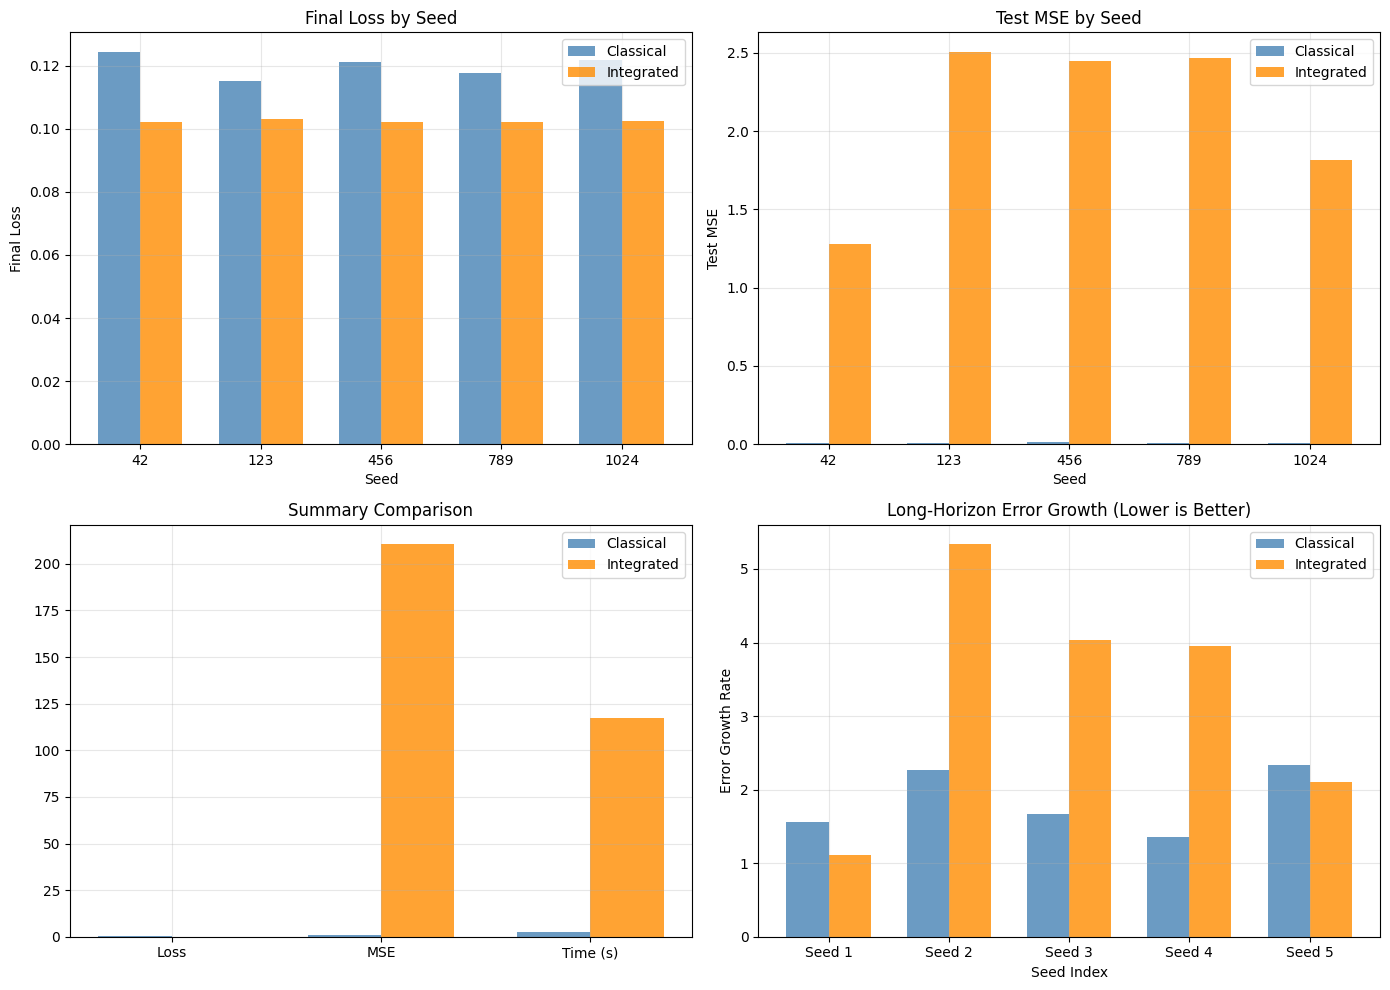

Figure saved to ..\experiments\results\fully_integrated\comparison_plots.png


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Final Loss Comparison
ax = axes[0, 0]
x_seeds = np.arange(len(CONFIG['seeds']))
width = 0.35
ax.bar(x_seeds - width/2, classical_losses, width, label='Classical', color='steelblue', alpha=0.8)
ax.bar(x_seeds + width/2, integrated_losses, width, label='Integrated', color='darkorange', alpha=0.8)
ax.set_xlabel('Seed')
ax.set_ylabel('Final Loss')
ax.set_title('Final Loss by Seed')
ax.set_xticks(x_seeds)
ax.set_xticklabels(CONFIG['seeds'])
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Test MSE Comparison
ax = axes[0, 1]
ax.bar(x_seeds - width/2, classical_mses, width, label='Classical', color='steelblue', alpha=0.8)
ax.bar(x_seeds + width/2, integrated_mses, width, label='Integrated', color='darkorange', alpha=0.8)
ax.set_xlabel('Seed')
ax.set_ylabel('Test MSE')
ax.set_title('Test MSE by Seed')
ax.set_xticks(x_seeds)
ax.set_xticklabels(CONFIG['seeds'])
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Summary Statistics
ax = axes[1, 0]
metrics = ['Loss', 'MSE', 'Time (s)']
classical_means = [np.mean(classical_losses), np.mean(classical_mses)*100, np.mean(classical_times)]
integrated_means = [np.mean(integrated_losses), np.mean(integrated_mses)*100, np.mean(integrated_times)]
x_metrics = np.arange(len(metrics))
ax.bar(x_metrics - width/2, classical_means, width, label='Classical', color='steelblue', alpha=0.8)
ax.bar(x_metrics + width/2, integrated_means, width, label='Integrated', color='darkorange', alpha=0.8)
ax.set_xticks(x_metrics)
ax.set_xticklabels(metrics)
ax.set_title('Summary Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Long-Horizon Error Growth
ax = axes[1, 1]
n_horizon = len(classical_horizon_growth)
x_horizon = np.arange(n_horizon)
ax.bar(x_horizon - width/2, classical_horizon_growth, width, 
       label='Classical', color='steelblue', alpha=0.8)
ax.bar(x_horizon + width/2, integrated_horizon_growth, width, 
       label='Integrated', color='darkorange', alpha=0.8)
ax.set_xlabel('Seed Index')
ax.set_ylabel('Error Growth Rate')
ax.set_title('Long-Horizon Error Growth (Lower is Better)')
ax.set_xticks(x_horizon)
ax.set_xticklabels([f'Seed {i+1}' for i in range(n_horizon)])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Figure saved to {results_dir / "comparison_plots.png"}')

## 6B.15 Summary

### What This Notebook Combines

| Component | From | Solves |
|-----------|------|--------|
| QAOA Optimizer | Notebook 03 | Local minima |
| Superposition Replay | Notebook 04 | Sample inefficiency |
| Gate-Enhanced Layers | Notebook 05 | Slow convergence |
| Error Correction Ensemble | Notebook 06 | Compounding errors |

### Key Metrics Measured

1. **Training Efficiency**: Wall-clock time
2. **Sample Efficiency**: Final loss with same data
3. **Final Performance**: Test MSE
4. **Long-Horizon Prediction**: Error growth rate
5. **Computational Cost**: Parameter count
6. **Statistical Significance**: Mann-Whitney U, Cohen's d

In [17]:
print('='*70)
print('Phase 6B: Fully Integrated - COMPLETE')
print('='*70)
print()
print('Components integrated:')
print('  - QAOA Optimizer (escapes local minima)')
print('  - Superposition Replay (sample efficiency)')
print('  - Gate-Enhanced Layers (better representations)')
print('  - Error Correction Ensemble (robust predictions)')
print()
print('Metrics measured:')
print('  - Training efficiency (time)')
print('  - Sample efficiency (loss)')
print('  - Final performance (MSE)')
print('  - Long-horizon prediction (error growth)')
print('  - Computational cost (params)')
print('  - Statistical significance (p-values)')
print()
print('Ready for comparison with individual approaches!')

Phase 6B: Fully Integrated - COMPLETE

Components integrated:
  - QAOA Optimizer (escapes local minima)
  - Superposition Replay (sample efficiency)
  - Gate-Enhanced Layers (better representations)
  - Error Correction Ensemble (robust predictions)

Metrics measured:
  - Training efficiency (time)
  - Sample efficiency (loss)
  - Final performance (MSE)
  - Long-horizon prediction (error growth)
  - Computational cost (params)
  - Statistical significance (p-values)

Ready for comparison with individual approaches!
